In [3]:
from keras.models import load_model


from sql_master import SQLHandling
from DQL_model import DQLModel
from dql_training import dQL_model_training
from trading_environment import TradingEnvironment
import config as conf
import boto3
import json
import pandas as pd
from helper_funktions import subplot_n_plots
import numpy as np

import time

This notebook is used to train dan test a dql model for stock market data. The model receives a state of the market and outputs a buy, sell or hold action.

# Loading data

Here the ML Model parameters which is currently deployed last 24 hours of stock data is loaded from the database. The data is used to optimize the model.

In [4]:
# loading current in use model from the s3 bucket
s3 = boto3.client('s3',
                  aws_access_key_id=conf.AWS_S3_USER_ID,
                  aws_secret_access_key=conf.AWS_S3_USER_PASSWORD)

# downloading the curren model so the hyperparameters can be fine-tuned
current_model = "dql_model_v1.h5"
s3.download_file(conf.AWS_S3_ML_MODEL_BUCKET_NAME, f'current_model/{current_model}', current_model)

# downloading the curren results of the evaluation scores of the current model
# so that there is a baseline for seeing if the fine-tuned model is better than the
# current one
s3.download_file(conf.AWS_S3_ML_MODEL_BUCKET_NAME, f'best_model/best_evaluation_results.json', 'best_evaluation_results.json')
with open('best_evaluation_results.json', 'r') as file:
    currentEvaluationResults = json.load(file)


# loading the stock data of the past 24 hours
sh = SQLHandling(host=conf.AWS_RDS_HOST,
                 user=conf.AWS_RDS_USER,
                 password=conf.AWS_RDS_PASSWORD,
                 port=int(conf.AWS_RDS_PORT),
                 database=conf.AWS_RDS_DB)

# we have data in minute intervalls: so 24*60/10 = 144
BTC_USDTBars = sh.get_n_laste_entries_from_table_by_order_colum("auto_input1","time_stamp",144)

trainingData = BTC_USDTBars.drop(columns=["close","time_stamp"])
closePrice = BTC_USDTBars[["close"]]

# initialing model parameters

In this section, the model parameters required for model training are initialized.

In [5]:
# curren time
current_time = time.strftime("%Y-%m-%dT%H", time.gmtime())
saveRetrainedModelAs = f"dql_model_v1_{current_time}"

windowSize = (30, trainingData.shape[1])
episodes = 21
batchSize = 60
dataSamples = len(trainingData) - 1
weights = current_model
dqlModel = DQLModel(windowSize, loadWeights=weights)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 30, 128)           640       
                                                                 
 dense_2 (Dense)             (None, 30, 64)            8256      
                                                                 
 dense_3 (Dense)             (None, 30, 32)            2080      
                                                                 
 reshape (Reshape)           (None, 960)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 1922      
                                                                 
Total params: 12,898
Trainable params: 12,898
Non-trainable params: 0
_________________________________________________________________


# retraining the model

In [6]:
retrainedModelName = dQL_model_training(windowSize, episodes, batchSize, dataSamples, dqlModel, trainingData, closePrice,TradingEnvironment,saveEachXEpisode=4,stepsBeforeTraining=10,saveModelParamsAs=saveRetrainedModelAs)

 87%|████████▋ | 99/114 [00:12<00:01, 10.70it/s]

AI Trader bought at: close    26500.0
Name: 128, dtype: float64
1/1 [==============================] - 0s 38ms/step
AI Trader bought at: close    26550.0
Name: 129, dtype: float64
1/1 [==============================] - 0s 40ms/step
AI Trader bought at: close    26555.01
Name: 130, dtype: float64
EPISODE: 20
batch train
tradeSteps 3
2/2 [==============================] - 0s 12ms/step


 89%|████████▊ | 101/114 [00:13<00:02,  6.12it/s]

1/1 [==============================] - 0s 38ms/step
AI Trader bought at: close    26555.01
Name: 131, dtype: float64
1/1 [==============================] - 0s 46ms/step


 90%|█████████ | 103/114 [00:13<00:01,  6.81it/s]

AI Trader bought at: close    26555.0
Name: 132, dtype: float64
1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 104/114 [00:13<00:01,  7.13it/s]

AI Trader bought at: close    26500.22
Name: 133, dtype: float64
AI Trader sold at:  close    26621.33
Name: 134, dtype: float64  Profit: 121.33
#################################################
total profit in episode 356.15
#################################################
1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 106/114 [00:13<00:00,  8.79it/s]

AI Trader bought at: close    26819.99
Name: 135, dtype: float64
1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 108/114 [00:13<00:00, 10.62it/s]

AI Trader sold at:  close    26884.62
Name: 136, dtype: float64  Profit: 64.63
#################################################
total profit in episode 420.78
#################################################
AI Trader bought at: close    26916.85
Name: 137, dtype: float64
1/1 [==============================] - 0s 34ms/step
AI Trader bought at: close    26899.0
Name: 138, dtype: float64
1/1 [==============================] - 0s 34ms/step


 96%|█████████▋| 110/114 [00:13<00:00, 10.50it/s]

AI Trader bought at: close    26923.45
Name: 139, dtype: float64


 96%|█████████▋| 110/114 [00:13<00:00,  7.97it/s]


Episode: 21/21


  0%|          | 0/114 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step
EPISODE: 21
batch train
tradeSteps 0
2/2 [==============================] - 0s 12ms/step


  1%|          | 1/114 [00:00<01:19,  1.43it/s]

1/1 [==============================] - 0s 56ms/step


  2%|▏         | 2/114 [00:00<00:40,  2.77it/s]

AI Trader bought at: close    26600.12
Name: 31, dtype: float64
1/1 [==============================] - 0s 42ms/step


  3%|▎         | 3/114 [00:00<00:27,  4.03it/s]

AI Trader bought at: close    26582.26
Name: 32, dtype: float64
1/1 [==============================] - 0s 43ms/step


  4%|▎         | 4/114 [00:01<00:21,  5.12it/s]

AI Trader bought at: close    26572.37
Name: 33, dtype: float64
AI Trader sold at:  close    26600.0
Name: 34, dtype: float64  Profit: -0.12
#################################################
total profit in episode -0.12
#################################################
AI Trader bought at: close    26647.43
Name: 36, dtype: float64
1/1 [==============================] - 0s 43ms/step


  7%|▋         | 8/114 [00:01<00:08, 12.65it/s]

AI Trader sold at:  close    26638.06
Name: 37, dtype: float64  Profit: -9.37
#################################################
total profit in episode -9.49
#################################################
1/1 [==============================] - 0s 39ms/step


  9%|▉         | 10/114 [00:01<00:08, 12.77it/s]

AI Trader bought at: close    26610.0
Name: 39, dtype: float64
AI Trader bought at: close    26610.23
Name: 40, dtype: float64
EPISODE: 21
batch train
tradeSteps 2
1/1 [==============================] - 0s 55ms/step


 11%|█         | 12/114 [00:01<00:14,  6.95it/s]

AI Trader bought at: close    26588.22
Name: 41, dtype: float64
1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 14/114 [00:01<00:11,  8.70it/s]

AI Trader sold at:  close    26587.58
Name: 42, dtype: float64  Profit: -22.42
#################################################
total profit in episode -31.91
#################################################
AI Trader bought at: close    26612.69
Name: 43, dtype: float64
1/1 [==============================] - 0s 34ms/step
AI Trader bought at: close    26603.62
Name: 44, dtype: float64
1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 16/114 [00:02<00:11,  8.19it/s]

AI Trader bought at: close    26586.7
Name: 45, dtype: float64
1/1 [==============================] - 0s 28ms/step
AI Trader bought at: close    26623.25
Name: 46, dtype: float64
1/1 [==============================] - 0s 52ms/step


 16%|█▌        | 18/114 [00:02<00:11,  8.41it/s]

AI Trader bought at: close    26700.0
Name: 47, dtype: float64
1/1 [==============================] - 0s 60ms/step
AI Trader bought at: close    26731.04
Name: 48, dtype: float64
AI Trader sold at:  close    26768.0
Name: 49, dtype: float64  Profit: 155.31
#################################################
total profit in episode 123.4
#################################################


 18%|█▊        | 20/114 [00:02<00:10,  9.39it/s]

1/1 [==============================] - 0s 53ms/step
AI Trader bought at: close    26720.0
Name: 50, dtype: float64
EPISODE: 21
batch train
tradeSteps 1
1/1 [==============================] - 0s 32ms/step


 19%|█▉        | 22/114 [00:03<00:16,  5.49it/s]

AI Trader bought at: close    26753.72
Name: 51, dtype: float64
AI Trader sold at:  close    26846.0
Name: 52, dtype: float64  Profit: 126.0
#################################################
total profit in episode 249.4
#################################################
AI Trader bought at: close    26900.81
Name: 53, dtype: float64
1/1 [==============================] - 0s 39ms/step


 22%|██▏       | 25/114 [00:03<00:11,  7.84it/s]

AI Trader sold at:  close    26825.0
Name: 54, dtype: float64  Profit: -75.81
#################################################
total profit in episode 173.59
#################################################
AI Trader bought at: close    26831.0
Name: 56, dtype: float64
1/1 [==============================] - 0s 42ms/step


 25%|██▍       | 28/114 [00:03<00:08, 10.35it/s]

AI Trader sold at:  close    26767.62
Name: 57, dtype: float64  Profit: -63.38
#################################################
total profit in episode 110.21
#################################################
1/1 [==============================] - 0s 37ms/step
AI Trader bought at: close    26735.94
Name: 58, dtype: float64
1/1 [==============================] - 0s 38ms/step


 26%|██▋       | 30/114 [00:03<00:08,  9.84it/s]

AI Trader bought at: close    26685.52
Name: 59, dtype: float64
AI Trader bought at: close    26682.0
Name: 60, dtype: float64
EPISODE: 21
batch train
tradeSteps 3
1/1 [==============================] - 0s 60ms/step


 28%|██▊       | 32/114 [00:04<00:14,  5.81it/s]

AI Trader sold at:  close    26710.0
Name: 61, dtype: float64  Profit: -25.94
#################################################
total profit in episode 84.27
#################################################
1/1 [==============================] - 0s 67ms/step


 30%|██▉       | 34/114 [00:04<00:11,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 36/114 [00:04<00:10,  7.52it/s]

1/1 [==============================] - 0s 35ms/step


 33%|███▎      | 38/114 [00:05<00:09,  8.06it/s]

1/1 [==============================] - 0s 29ms/step
AI Trader bought at: close    26593.84
Name: 68, dtype: float64
1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 40/114 [00:05<00:08,  8.56it/s]

AI Trader bought at: close    26551.22
Name: 69, dtype: float64
1/1 [==============================] - 0s 44ms/step
AI Trader bought at: close    26536.87
Name: 70, dtype: float64
EPISODE: 21
batch train
tradeSteps 3
1/1 [==============================] - 0s 55ms/step


 37%|███▋      | 42/114 [00:06<00:14,  5.01it/s]

AI Trader bought at: close    26543.99
Name: 71, dtype: float64
1/1 [==============================] - 0s 73ms/step


 38%|███▊      | 43/114 [00:06<00:13,  5.16it/s]

AI Trader bought at: close    26539.19
Name: 72, dtype: float64
1/1 [==============================] - 0s 46ms/step


 39%|███▊      | 44/114 [00:06<00:12,  5.44it/s]

AI Trader sold at:  close    26569.91
Name: 73, dtype: float64  Profit: -23.93
#################################################
total profit in episode 60.34
#################################################
1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 45/114 [00:06<00:11,  5.96it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 46/114 [00:06<00:10,  6.50it/s]

1/1 [==============================] - 0s 46ms/step


 41%|████      | 47/114 [00:06<00:09,  7.01it/s]

AI Trader bought at: close    26539.99
Name: 76, dtype: float64
AI Trader sold at:  close    26512.0
Name: 77, dtype: float64  Profit: -27.99
#################################################
total profit in episode 32.35
#################################################
1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 49/114 [00:06<00:06,  9.30it/s]

AI Trader bought at: close    26510.0
Name: 78, dtype: float64
AI Trader bought at: close    26564.51
Name: 79, dtype: float64
1/1 [==============================] - 0s 35ms/step
AI Trader bought at: close    26566.34
Name: 80, dtype: float64
EPISODE: 21
batch train
tradeSteps 3
2/2 [==============================] - 0s 8ms/step


 45%|████▍     | 51/114 [00:07<00:10,  6.06it/s]

1/1 [==============================] - 0s 62ms/step


 46%|████▌     | 52/114 [00:07<00:09,  6.24it/s]

AI Trader bought at: close    26542.65
Name: 81, dtype: float64
1/1 [==============================] - 0s 59ms/step


 46%|████▋     | 53/114 [00:07<00:09,  6.33it/s]

AI Trader bought at: close    26575.0
Name: 82, dtype: float64
1/1 [==============================] - 0s 75ms/step
AI Trader sold at:  close    26629.86
Name: 83, dtype: float64  Profit: 119.86
#################################################
total profit in episode 152.21
#################################################


 47%|████▋     | 54/114 [00:07<00:09,  6.15it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 55/114 [00:07<00:08,  6.66it/s]

1/1 [==============================] - 0s 73ms/step


 50%|█████     | 57/114 [00:08<00:06,  8.23it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 58/114 [00:08<00:06,  8.37it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 59/114 [00:08<00:06,  8.60it/s]

1/1 [==============================] - 0s 76ms/step


 53%|█████▎    | 60/114 [00:08<00:06,  8.11it/s]

EPISODE: 21
batch train
tradeSteps 0
2/2 [==============================] - 0s 8ms/step


 54%|█████▎    | 61/114 [00:08<00:10,  4.88it/s]

AI Trader bought at: close    26469.03
Name: 91, dtype: float64
1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 63/114 [00:09<00:07,  7.13it/s]

AI Trader sold at:  close    26468.76
Name: 92, dtype: float64  Profit: -0.27
#################################################
total profit in episode 151.94
#################################################
1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 64/114 [00:09<00:06,  7.34it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 65/114 [00:09<00:06,  7.84it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 67/114 [00:09<00:05,  9.27it/s]

1/1 [==============================] - 0s 61ms/step


 61%|██████▏   | 70/114 [00:09<00:03, 12.01it/s]

AI Trader bought at: close    26480.75
Name: 99, dtype: float64
1/1 [==============================] - 0s 41ms/step
AI Trader bought at: close    26474.06
Name: 100, dtype: float64
EPISODE: 21
batch train
tradeSteps 2
2/2 [==============================] - 0s 19ms/step


 63%|██████▎   | 72/114 [00:10<00:06,  6.20it/s]

AI Trader sold at:  close    26488.05
Name: 101, dtype: float64  Profit: 7.3
#################################################
total profit in episode 159.24
#################################################
1/1 [==============================] - 0s 28ms/step
AI Trader bought at: close    26470.89
Name: 102, dtype: float64
AI Trader sold at:  close    26491.24
Name: 103, dtype: float64  Profit: 20.35
#################################################
total profit in episode 179.59
#################################################
AI Trader bought at: close    26497.23
Name: 104, dtype: float64
1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 76/114 [00:10<00:04,  9.35it/s]

AI Trader bought at: close    26520.0
Name: 105, dtype: float64
1/1 [==============================] - 0s 48ms/step
AI Trader sold at:  close    26570.25
Name: 106, dtype: float64  Profit: 73.02
#################################################
total profit in episode 252.61
#################################################
1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 78/114 [00:10<00:04,  8.87it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 80/114 [00:10<00:03,  8.67it/s]

1/1 [==============================] - 0s 36ms/step
EPISODE: 21
batch train
tradeSteps 0
1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 82/114 [00:11<00:06,  5.04it/s]

AI Trader bought at: close    26486.16
Name: 111, dtype: float64
1/1 [==============================] - 0s 45ms/step


 73%|███████▎  | 83/114 [00:11<00:05,  5.40it/s]

AI Trader bought at: close    26469.99
Name: 112, dtype: float64
1/1 [==============================] - 0s 30ms/step
AI Trader bought at: close    26498.78
Name: 113, dtype: float64
1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 85/114 [00:12<00:04,  6.26it/s]

AI Trader bought at: close    26424.0
Name: 114, dtype: float64
1/1 [==============================] - 0s 41ms/step


 75%|███████▌  | 86/114 [00:12<00:04,  6.63it/s]

AI Trader bought at: close    26496.94
Name: 115, dtype: float64
1/1 [==============================] - 0s 47ms/step


 76%|███████▋  | 87/114 [00:12<00:03,  6.92it/s]

AI Trader bought at: close    26518.47
Name: 116, dtype: float64
1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 88/114 [00:12<00:03,  7.35it/s]

AI Trader bought at: close    26579.99
Name: 117, dtype: float64
AI Trader sold at:  close    26641.88
Name: 118, dtype: float64  Profit: 155.72
#################################################
total profit in episode 408.33
#################################################
1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 90/114 [00:12<00:02,  9.36it/s]

AI Trader bought at: close    26649.8
Name: 119, dtype: float64
AI Trader bought at: close    26650.0
Name: 120, dtype: float64
EPISODE: 21
batch train
tradeSteps 2
2/2 [==============================] - 0s 7ms/step


 81%|████████  | 92/114 [00:13<00:03,  7.09it/s]

AI Trader sold at:  close    26718.38
Name: 121, dtype: float64  Profit: 68.58
#################################################
total profit in episode 476.91
#################################################
1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 94/114 [00:13<00:02,  8.56it/s]

1/1 [==============================] - 0s 61ms/step


 84%|████████▍ | 96/114 [00:13<00:02,  7.90it/s]

1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 97/114 [00:13<00:02,  7.43it/s]

1/1 [==============================] - 0s 30ms/step
AI Trader bought at: close    26549.97
Name: 127, dtype: float64
AI Trader bought at: close    26500.0
Name: 128, dtype: float64
1/1 [==============================] - 0s 32ms/step


 88%|████████▊ | 100/114 [00:13<00:01, 10.14it/s]

AI Trader bought at: close    26550.0
Name: 129, dtype: float64
1/1 [==============================] - 0s 76ms/step
AI Trader bought at: close    26555.01
Name: 130, dtype: float64
EPISODE: 21
batch train
tradeSteps 4
2/2 [==============================] - 0s 8ms/step
AI Trader bought at: close    26555.01
Name: 131, dtype: float64

 89%|████████▉ | 102/114 [00:14<00:01,  6.73it/s]


AI Trader bought at: close    26555.0
Name: 132, dtype: float64
AI Trader bought at: close    26500.22
Name: 133, dtype: float64
1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 105/114 [00:14<00:00,  9.42it/s]

AI Trader bought at: close    26621.33
Name: 134, dtype: float64
1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 107/114 [00:14<00:00, 10.73it/s]

AI Trader bought at: close    26819.99
Name: 135, dtype: float64
AI Trader bought at: close    26884.62
Name: 136, dtype: float64
1/1 [==============================] - 0s 49ms/step
AI Trader bought at: close    26916.85
Name: 137, dtype: float64
1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 109/114 [00:14<00:00,  9.72it/s]

AI Trader bought at: close    26899.0
Name: 138, dtype: float64
1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 110/114 [00:14<00:00,  7.39it/s]

AI Trader bought at: close    26923.45
Name: 139, dtype: float64


Model Evaluation
In this section, the results obtained from the model training are visualized and analyzed. The evaluation focuses on specific labels, namely "trades" and "totalProfit".

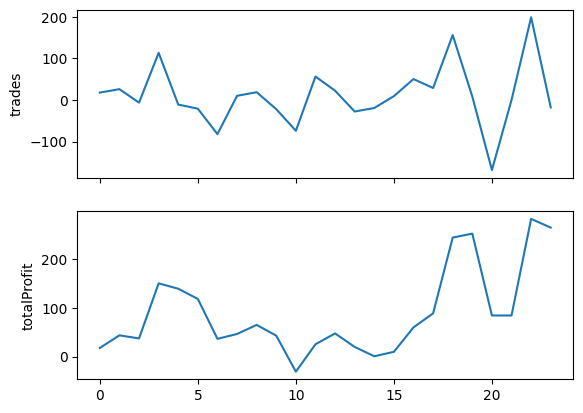

In [7]:
with open('trader_stats_episode_4_model_v1.json', 'r') as file:
    traderStats = json.load(file)

timeForPlot = range(len(trainingData))

# after n episodes the results are plotted
subplot_n_plots(range(len(traderStats["trades"])), [entry['trade_profit'] for entry in traderStats["trades"]],
            [entry['total_profit'] for entry in traderStats["trades"]],
            labels=["trades", "totalProfit"])

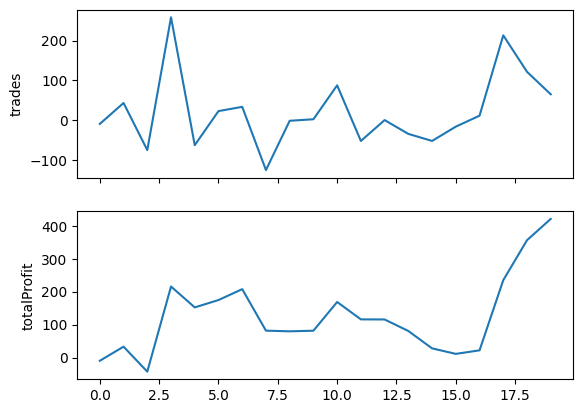

In [8]:
with open('trader_stats_episode_20_model_v1.json', 'r') as file:
    traderStats = json.load(file)

timeForPlot = range(len(trainingData))

# after n episodes the results are plotted
subplot_n_plots(range(len(traderStats["trades"])), [entry['trade_profit'] for entry in traderStats["trades"]],
            [entry['total_profit'] for entry in traderStats["trades"]],
            labels=["trades", "totalProfit"])

## preprocessing th test data

In this phase, the test data is loaded and preprocessed to prepare it for model testing. The test data used to assess whether the new model outperforms the old model spans from January 2023 to May 2023. It is important to note that this data has not been utilized for training any model. The data is reshaped to facilitate input for the new model in making predictions.

In [9]:
testData = sh.get_table_as_df("test_data_model_v1_BTC_USDT")
testClose = testData[["close"]]
testData = testData.drop(columns=["close", "time_stamp", "index"])

In [10]:
env = TradingEnvironment(testData, windowSize, testClose)
states = env.allStates
reshaped_input_data = np.transpose(env.allStates, (0, 1, 2))


In [11]:
model_to_test = load_model(retrainedModelName)
model_to_test.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 30, 128)           640       
                                                                 
 dense_2 (Dense)             (None, 30, 64)            8256      
                                                                 
 dense_3 (Dense)             (None, 30, 32)            2080      
                                                                 
 reshape (Reshape)           (None, 960)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                 1922      
                                                                 
Total params: 12,898
Trainable params: 12,898
Non-trainable params: 0
_________________________________________________________________


In [12]:
predictions = model_to_test.predict(reshaped_input_data)

2187/2187 [==============================] - 19s 8ms/step


To evaluate the model, the actions to be taken by the model are extracted into a dataframe. In this context, a prediction of 0 indicates a recommendation to buy the stock, while a prediction of 1 signifies a suggestion to sell the stock. Additionally, the ground truth, which represents the actual actions that should be taken, is extracted and organized into a dataframe. The ground truth is determined by comparing the current close price of the stock to the close price of the stock three steps into the future. If the price is higher, the corresponding action is 0, whereas if the price is lower, the action is 1. Subsequently, the predictions and the ground truth are compared to calculate the accuracy of the model.

In [13]:
pred = pd.DataFrame([], columns=["pos_predictions"])

def make_action_pos_column(predictions):
    action_pos = []
    for i in range(len(predictions)):
        if predictions[i][0] > predictions[i][1]:
            action_pos.append(0)
        else:
            action_pos.append(1)
    return action_pos

pred["pos_predictions"] = make_action_pos_column(predictions)

In [14]:
groundTruth = pd.DataFrame([], columns=["value"])
groundTruth["value"] = testClose.pct_change(3).iloc[3:]

# Convert 'value' column to a numeric data type
groundTruth["value"] = pd.to_numeric(groundTruth["value"], errors='coerce')

# Create a column 'action_pos' and use apply with a lambda function
groundTruth['action_pos'] = groundTruth['value'].apply(lambda x: 0 if x > 0 else 1)

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

actual = groundTruth[["action_pos"]][-len(pred):]
predicted = pred[["pos_predictions"]][-len(pred):]
cm = confusion_matrix(actual, predicted)
print("Confusion Matrix:")
print(cm)

# Calculate the accuracy score
accuracy = accuracy_score(actual, predicted)
print("Accuracy:", accuracy)

# make a json file with the results
newModelResults = {
    "accuracy": accuracy,
}
# save the results to a json file and a s3 bucket
with open('new_model_evaluation_results.json', 'w') as fp:
    json.dump(newModelResults, fp)

Confusion Matrix:
[[13468 21258]
 [14185 21060]]
Accuracy: 0.4934615769390176


# comparing curren to new model

In the subsequent phase, the evaluation results of the current model are retrieved and compared to the results obtained from the new model. If the performance of the new model surpasses that of the current model, the new model is saved to the S3 bucket by overwriting the existing current model. This process ensures that the most effective and superior model is stored for future use.

In [16]:
if newModelResults['accuracy'] > currentEvaluationResults['accuracy']:
    s3.upload_file(f'new_model_evaluation_results.json', conf.AWS_S3_ML_MODEL_BUCKET_NAME, f'best_model/best_evaluation_results.json')
    s3.upload_file(f'{retrainedModelName}.h5', conf.AWS_S3_ML_MODEL_BUCKET_NAME, f'best_model/{retrainedModelName}.h5')
    print("New model is better than the current model. "
          "New model will be used to make trades.")
else:
    print("New model is not better than the current model. Current model is kept.")
    # new model is saved to historical models folder
    s3.upload_file(f'{retrainedModelName}', conf.AWS_S3_ML_MODEL_BUCKET_NAME, f'trained_models_history/dql_model_v1.h5')

New model is not better than the current model. Current model is kept.
